In [151]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import squarify
import os
import numpy as np
from adjustText import adjust_text
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from difflib import SequenceMatcher
import unidecode
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from PIL import Image
import math
import matplotlib.lines as lines
import matplotlib.patches as patches
from highlight_text import HighlightText, ax_text, fig_text

In [207]:
df = pd.read_csv(r'C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Transfermarket\net_spend.csv')
ratings  = pd.read_html('https://projects.fivethirtyeight.com/soccer-predictions/global-club-rankings/')[0]
ratings.columns = ratings.columns.get_level_values(1)
ratings = ratings[['team','League','spi','League country']]
salaries = pd.read_csv(r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Capology\salaries.csv")
salaries['Weekly Gross(IN EUR)'] = salaries['Weekly Gross(IN EUR)'].apply(lambda x:int(x[2:].replace(',','')))
salaries['Annual Gross(IN EUR)'] = salaries['Annual Gross(IN EUR)'].apply(lambda x:int(x[2:].replace(',','')))
salaries_sum = salaries.groupby('Club').sum().reset_index()
tmarkt_clubs = df['Club'].tolist()
cap_clubs = salaries_sum['Club'].tolist()
def similar(a,b):
    return SequenceMatcher(None,a,b).ratio()
similar_dict= dict() 
for tochange in cap_clubs:
    tochange = unidecode.unidecode(tochange)
    most = (0,0)
    for tmarkt in tmarkt_clubs:
        if tochange in unidecode.unidecode(tmarkt):
            most = (1,tmarkt)
            break
        tmp = similar(tochange,tmarkt)
        if tmp < 0.70:
            continue
        elif tmp > most[0] and tmarkt not in similar_dict.values():
            most = (tmp,tmarkt)
            
    similar_dict[tochange] = most[1]
similar_dict = {k:v for k,v in similar_dict.items() if v !=0}
salaries_sum['Club'] = salaries_sum['Club'].map(similar_dict)
salaries['Club'] = salaries['Club'].map(similar_dict)
df = df.merge(salaries_sum[['Weekly Gross(IN EUR)','Club']],how='left',on='Club')
players = salaries.merge(df[['Club','League']],how='left',on='Club')
players = players[players['League'].isin(['Bundesliga', 'LaLiga', 'Ligue 1','Premier League','Serie A'])]
df['Club'] = df['Club'].str.replace('FC','')
df = df[df['League'].isin(['Bundesliga', 'LaLiga', 'Ligue 1','Premier League','Serie A'])]
countries = ['England', 'Germany', 'Spain', 'France','Italy']
leagues = ['Premier League', 'Bundesliga', 'La Liga','Ligue 1','Serie A']
final = pd.DataFrame()
for i in range(5):
    tmp = ratings[(ratings['League country'] == countries[i]) & (ratings['League'] == leagues[i])]
    final = pd.concat([final,tmp])
ratings = final
df['Scaled_Total'] = df['Total']/100000


In [209]:
images = []
for file in os.listdir(r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams\\"):
    images.append(file.replace('.png',''))
def similar(a,b):
    return SequenceMatcher(None,a,b).ratio()
similar_dict= dict() 
for tochange in df['Club']:
    most = (0,0)
    for tmarkt in images:
        if (unidecode.unidecode(tochange) in unidecode.unidecode(tmarkt)) or (unidecode.unidecode(tmarkt) in unidecode.unidecode(tochange)):
            most = (1,tmarkt)
            break
        tmp = similar(tochange,tmarkt)
        if tmp < 0.70:
            continue
        elif tmp > most[0] and tmarkt not in similar_dict.values():
            most = (tmp,tmarkt)
    similar_dict[tochange] = most[1]
df['Club'] = df['Club'].map(similar_dict) 

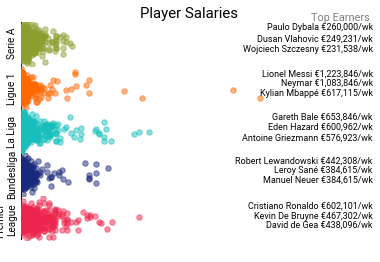

In [213]:
def plot_salary(df,ax,colors):
    for i,league in enumerate(['Premier League', 'Bundesliga', 'LaLiga', 'Ligue 1', 'Serie A']):
        subset = df[df['League'] == league]
        new = ax.inset_axes([0,i/5,0.75,0.2])
        y = np.random.normal(0,0.04,size=(len(subset)))
        new.scatter(x=subset['Weekly Gross(IN EUR)'],y=y,alpha=0.5,s=30,zorder=-1,color=colors[i])
        new.set_xlim([-2,df['Weekly Gross(IN EUR)'].max()*1.05])
        new.axis('off')
        if league == 'LaLiga':
            league = 'La Liga'
        league_text = new.text(-20000,0,league,font=font,va='center',ha='right',fontsize=10,rotation='vertical',wrap=True)
        league_text._get_wrap_line_width = lambda : 50
        to_label = subset.sort_values('Weekly Gross(IN EUR)',ascending= False).head(3)
        y = 0.06
        for idx,row in to_label.iterrows():
            text = row['Player'] + " €{:,}/wk".format(row['Weekly Gross(IN EUR)'])
            new.text(1800000,y,text,font=font,va='bottom',ha='right',fontsize=9,fontweight='normal')
            y = y-0.06
    ax.vlines(0,-0.5,5,color='black',linewidth=2)
    ax.text(0.25,4.7,'Player Salaries',ha='center',va='center',font=font,fontsize=15)
    ax.text(0.52,4.55,'Top Earners', ha='right',font=font,fontsize=11,color='gray')
    ax.axis('off')
    ax.set_ylim([-0.5,4.5])
    ax.set_xlim(0,0.5)
    return ax
fig,ax = plt.subplots()
ax = plot_salary(players,ax,colors)


In [211]:
def plot_treemap(ax,df,edgecolor,norm_x,norm_y,colors):
    #filter by wages
    #df = df.groupby('League').mean()
    normed = squarify.normalize_sizes(df['Weekly Gross(IN EUR)'],norm_x,norm_y)
    rects = squarify.padded_squarify(normed,0,0,norm_x,norm_y)
    ax = squarify.plot(df['Weekly Gross(IN EUR)'],norm_x,norm_y,color=colors,edgecolor=edgecolor,ax=ax)
    i = 0
    leagues = ['Premier League', 'Bundesliga', 'La Liga', 'Ligue 1', 'Serie A']
    leagues.sort()
    for l, r in zip(df['Weekly Gross(IN EUR)'], rects):
        x, y, dx, dy = r["x"]/norm_x, r["y"]/norm_y, r["dx"]/norm_x, r["dy"]/norm_y
        if (dx>0.015) and (dy> 0.015):
            imageax = inset_axes(ax,width = '100%',height = '100%',loc='center',bbox_to_anchor=(x+dx/4, y+dy/4,dx/2,dy/2),bbox_transform=ax.transAxes)
            path = r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Leagues" + '\\' + leagues[i] +'.png'
            im = plt.imread(path)
            imageax.imshow(im)
            imageax.axis('off') 
        i += 1
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(50,102,'Average Player Salary',font=font,ha='center')
    ax.axis('off')
    return ax
# fig,ax = plt.subplots()
# plot_treemap(ax,test,'black',100,100,colors)

In [156]:
def get_logo(clubs):
    logo_urls = []
    for club in clubs:
        #name = club.replace('FC','')
        name = unidecode.unidecode(club)
        first = name.split()[0] 
        if os.path.exists(rf'C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams\{name}.png'):
            name = name + '.png'
            logo_urls.append(name)
        elif os.path.exists(rf'C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams\{first}.png'):
            name = first + '.png'
            logo_urls.append(name)
        else: 
            print('Error ', club)
            print(rf'C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams\{name}.png')
    return logo_urls

In [157]:
def plot_swarm(ax,ratings,colors,statcolor,textcolor,font,fontsize,axissize,upsets):
    '''
    Takes a df and outputs the swamrplot with the top 3 labeled 
    '''
    palette = sns.color_palette(colors,5)
    ax = sns.swarmplot(x='League',y='spi',data=ratings,palette=palette,ax=ax,size=6)
    ymin = ratings['spi'].min() + 5
    texts = []
    # xbars = [-0.2,0.8,1.8,2.8,3.8]
    # upsets['scaled'] = upsets[0] + 37.3
    # ax.bar(xbars,width=0.1,height=upsets['scaled'],color=colors,alpha=0.75)
    x=0
    for league in ['Premier League', 'Bundesliga', 'La Liga', 'Ligue 1', 'Serie A']:
        tmp = ratings[ratings['League'] ==league]
        to_label = tmp.sort_values('spi',ascending=False).head(3)
        for idx in range(3):
            x_offset = [-0.01,0,0.01]
            t= ax.text(x_offset[idx]+x,to_label['spi'].iloc[idx],to_label['team'].iloc[idx],color=textcolor,size=fontsize,font=font)
            texts.append(t)
        # upset_s = upsets[upsets['league']==league]
        # ax.text(xbars[i],upset_s['scaled']+0.8,upset_s[0].iloc[0],va='center',ha='center',color=textcolor,size=fontsize+1,font=font)
        ax.hlines(tmp['spi'].median(),xmin=x-0.3,xmax=x+0+0.3,linestyle='--',color=statcolor,linewidth=0.8)
        x+=1
    ax.set_ylim([ymin-1,97])
    ax.set_ylabel('Team Strength',font= font,fontsize=fontsize,color=textcolor)
    ax.set_xticks([])
    ax.set_yticks(np.arange(ymin,101,10),fontsize=axissize)
    adjust_text(texts,arrowprops=dict(arrowstyle='-', color=textcolor,connectionstyle='arc3,rad=0.2'),force_points = 8, force_text=2,ha='center',precision = 0.5)
    ax.axis('off')
    return ax
# fig,ax = plt.subplots()
# fig.set_size_inches(20,12)
# # colors = ['#DB5461','#B1740F','#1F271B','#EE5622','#17B890']
# # colors = ['#DB5461','#3D5467','#3DA5D9','#D84797','#47A025']
# colors = ['#ED254E','#2D2E2E','#17BEBB','#004F2D','#FF6700']
# fig.patch.set_facecolor(bg_color)
# ax = plot_swarm(ax,ratings,colors,statcolor,textcolor,font,fontsize,axissize,upsets)

In [158]:
def plot_league_bar_old(ax,df,width,bg_color,color,edgecolor):
    cmap=LinearSegmentedColormap.from_list('test',[bg_color,color], N=256)
    colors = plt.cm.ScalarMappable(cmap=cmap).to_rgba(df['Weekly Gross(IN EUR)']/df['Weekly Gross(IN EUR)'].mean())
    ax.bar(x= df['Club'],height = df['Scaled_Total'],width=width,color=colors,edgecolor=edgecolor) #default width = 0.8
    logo_urls= get_logo(df['Club'])
    for i, (idx,row) in enumerate(df.iterrows()):
        path = r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams" + '\\' + logo_urls[i]
        im = Image.open(path)
        if row['Scaled_Total'] > 0:
            ymax = row['Scaled_Total'] + 35
            ax.imshow(im,extent = [i-width+0.05,i+width,row['Scaled_Total'],ymax], zorder=2,alpha=0.9)
        else:
            ymax = row['Scaled_Total'] -50
            ax.imshow(im,extent = [i-width+0.05,i+width,ymax,row['Scaled_Total']-7], zorder=2,alpha=0.9)
        
    plt.xlim(-1, len(df)+1)
    plt.ylim(-600,300)
    ax.hlines(0,-2, len(df)+0.2,color=edgecolor,linewidth=0.8,alpha=0.8)
    ax.axis('off')
    ax.set_aspect('auto')
    return ax 

In [159]:
def plot_league_bar(ax,df,width,bg_color,color,edgecolor,font):
    cmap=LinearSegmentedColormap.from_list('test',[bg_color,color], N=256)
    colors = plt.cm.ScalarMappable(cmap=cmap).to_rgba(df['Weekly Gross(IN EUR)']/df['Weekly Gross(IN EUR)'].mean())
    # ax.barh(y= df['Club'],width= df['Scaled_Total'],height=width,color=colors,edgecolor=edgecolor) #default width = 0.8
    ax.barh(y= df['Club'],width= df['Scaled_Total'],height=width,color=colors,edgecolor=edgecolor) #default width = 0.8
    # logo_urls= get_logo(df['Club'])
    for i, (idx,row) in enumerate(df.iterrows()):
        # path = r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams" + '\\' + logo_urls[i]
        # im = Image.open(path)
        if row['Scaled_Total'] > 0:
            ymax = row['Scaled_Total'] + 30
            # ax.imshow(im,extent = [row['Scaled_Total'],ymax,i-width+0.05,i+width], zorder=2,alpha=0.9)
            club_text = ax.text(ymax,i,s=row['Club'],ha='left',va='center',fontsize=9,font=font)

        else:
            ymax = row['Scaled_Total'] -20
            #ax.imshow(im,extent = [ymax,row['Scaled_Total']-7,i-width+0.05,i+width], zorder=2,alpha=0.9)
            club_text = ax.text(ymax,i,s=row['Club'],ha='right',va='center',fontsize=9,font=font)
        club_text._get_wrap_line_width = lambda : 40
    plt.ylim(-1, len(df)+6)
    plt.xlim(df['Scaled_Total'].min()-400,df['Scaled_Total'].max()+400)
    ax.vlines(0,-2, len(df)+0.2,color=edgecolor,linewidth=0.8,alpha=0.8)
    ax.axis('off')
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_aspect('auto')
    return ax 
# fig,ax = plt.subplots()
# subset = df[df['League']=='Bundesliga']
# ax = plot_league_bar(ax,subset,width,bg_color,'red',edgecolor,font)


In [160]:
def plot_mv(df,ax,bottom,top,left,right,scalefactor,textcolor,ginicolor,font):
    #takes in the number of values and the necessary dimensions, to create the coordiantes for the waffle and returns a dataframe
    '''
    df: dataframe filtered by season and by situation
    bottom, top,left,right: dimensions of the waffle
    '''

    #get dimensions 
    points =pd.DataFrame()
    df = df.sort_values('Market Value',ascending=False)
    points['Club'] = df['Club']
    count = len(df)
    length = math.ceil(right - left +1)
    height = math.ceil(count/length)
    #get coords
    points['x'] = np.tile(np.arange(left,right+1),height)[:count]
    points['y'] = np.repeat(np.arange(top,bottom,-1),length)[:count]
    points['size'] = (df['Market Value']/100000)*scalefactor
    #ax.scatter(points['x'],points['y'],s=points['size'],edgecolors='black',alpha=0.5)
    logo_urls= get_logo(df['Club'])
    for i in range(count):
        path = r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\Logos\Teams" + '\\' + logo_urls[i]
        im = plt.imread(path)
        #imageax = inset_axes(ax,width='100%',height='100%',loc='center',bbox_to_anchor=(points['x'].iloc[i],points['y'].iloc[i],0.2,0.2),bbox_transform=ax.transAxes)
        #imageax.imshow(im)
        imsize = points['size'].iloc[i] /10000
        ax.imshow(im,extent=[points['x'].iloc[i]-imsize, points['x'].iloc[i]+imsize,points['y'].iloc[i] - imsize,points['y'].iloc[i] +imsize],zorder=2 )
    ax.set_xlim([-0.6,5.5])
    ax.set_ylim([-0.5,6.8])
    ax.axis('off')

    #stat text
    ax.hlines(1.5,-0.6,5.45,color =statcolor,linewidth=0.8,alpha=0.9)
    ax.vlines([-0.6,5.45],1.5,1.7,color = statcolor,linewidth=0.8,alpha=0.9)
    ax.vlines(2.3,1.2,1.5,color = statcolor,linewidth=0.8,alpha=0.9)

    def gini(x):
        #https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy
        # Mean absolute difference
        x = x.to_numpy()
        mad = np.abs(np.subtract.outer(x, x)).mean()
        # Relative mean absolute difference
        rmad = mad/np.mean(x)
        # Gini coefficient
        g = 0.5 * rmad
        return np.round(g,2)
    gini_val = gini(df['Market Value'])
    ax.text(5.5,-0.001,gini_val,fontsize=24,color=ginicolor,ha='right',va='center',font=font)
    #ax.text(4.6,0,'Gini Coefficient',fontsize=10,color=ginicolor,ha='center',va='center',font=font)

    highest = np.round(df.head(1)['Market Value'].iloc[0]/100000,1)
    club = df.head(1)['Club'].iloc[0]
    ax.text(-0.6,0.5,f'Highest: {club} ({highest}m)',fontsize=10,color=textcolor,ha='left',va='center',font=font)

    lowest = np.round(df.tail(1)['Market Value'].iloc[0]/100000,1)
    club = df.tail(1)['Club'].iloc[0]
    ax.text(-0.6,0,f'Lowest: {club} ({lowest}m)',fontsize=10,color=textcolor,ha='left',va='center',font=font)
    return ax,points


In [161]:
def plot_upsets(ax,upsets,font,colors,bg_color):
    ax.bar(upsets['league'],height=upsets[0],color=colors)
    for i,league in enumerate(upsets['league']):
        y = upsets[0].iloc[i]
        x = i
        # ax.imshow(im,extent=[x+0.5,x+5.7,y-0.4,y+0.4],zorder=2,aspect ='auto')
        ax.text(x,y-2,upsets[0].iloc[i],color='white',font=font,fontsize=12,ha='center')
        league_text = ax.text(x,y+2,league,color='black',font=font,fontsize=12,ha='center',wrap=True)
        league_text._get_wrap_line_width = lambda : 40
    ax.text(2,27,'Number of Upsets in the 21/22 Season',ha='center',va='center',font=font,size=15)
    ax.text(4.5,-2,'Upsets are outcomes which FiveThirtEight predicted\n a less than 20% probability of happening',ha='right',fontsize=8)
    ax.axis('off')
    ax.set_facecolor(bg_color)
    ax.set_ylim([-5,23])
    ax.hlines(0,-0.5,4.5,linewidth=5,color='black')
    return ax
# fig,ax = plt.subplots()
# ax = plot_upsets(ax,upsets,font,colors,bg_color)

In [172]:
def plot_spend(ax,df,bg_color,colors):
    total = df.groupby('League').sum()[['17/18','18/19','19/20','20/21','21/22']]/1000000
    total.columns = ['17/18','18/19','19/20','20/21','21/22']
    ax = total.T[['Premier League', 'Bundesliga', 'LaLiga', 'Ligue 1', 'Serie A']].plot(color=colors,ax=ax)
    to_plot = total.reindex(['Premier League', 'Bundesliga', 'LaLiga', 'Ligue 1', 'Serie A']).melt()
    ax.scatter(x=to_plot['variable'],y=to_plot['value'],color=np.tile(colors,5),edgecolor=bg_color,s=50)
    ax.get_legend().remove()
    ax.text(2,43,'Net Transfer Spending of the Past 5 Years ',ha='center',va='center',font=font,size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both',length=0,which='both')
    ax.text(4,30,'Figures in Millions',font=font,size=9,alpha=0.9,color='grey',style='italic',ha='right')
    ax.set_facecolor(bg_color)
    plt.xticks()
    ax.set_xlim([0,4.2])
    ax.hlines(0,0,4.2,linewidth=1,linestyles='--',color='grey')
    return ax
# fig,ax = plt.subplots()
# _= plot_spend(ax,df,bg_color,colors)

In [214]:
def plot_master(fig,ratings,df,colors,statcolor,textcolor,font,fontsize,axissize,ginicolor,bg_color,upsets):
    gs = GridSpec(5,5,figure=fig)
    axs = []
    ax = fig.add_subplot(gs[0,2:5])
    ax = plot_spend(ax,df,bg_color,colors)
    axs.append(ax)
    # ax = fig.add_subplot(gs[0,1])
    # ax = plot_upsets(ax,upsets,font,colors,bg_color)
    # axs.append(ax)
    ax = fig.add_subplot(gs[0,0:2])
    ax = plot_salary(players,ax,colors)
    axs.append(ax)
    main = fig.add_subplot(gs[1:3,:])
    main = plot_swarm(main,ratings,colors,statcolor,textcolor,font,fontsize,axissize,upsets)
    main.text(-0.40,74.5,('League Median'),color=statcolor,size=fontsize-1,fontweight='roman')
    axs.append(main)
    leagues = ['Premier League', 'Bundesliga', 'LaLiga', 'Ligue 1', 'Serie A']
    for i in range(5):
        ax = fig.add_subplot(gs[3,i])
        axs.append(ax)
        subset = df[df['League'] == leagues[i]]
        ax = plot_league_bar(ax,subset,width,bg_color,colors[i],edgecolor,font)
        ax = fig.add_subplot(gs[4,i])
        axs.append(ax)
        ax= plot_mv(subset,ax,0,5,0,5,5,textcolor,ginicolor,font)

    plt.tight_layout()
    return fig,axs

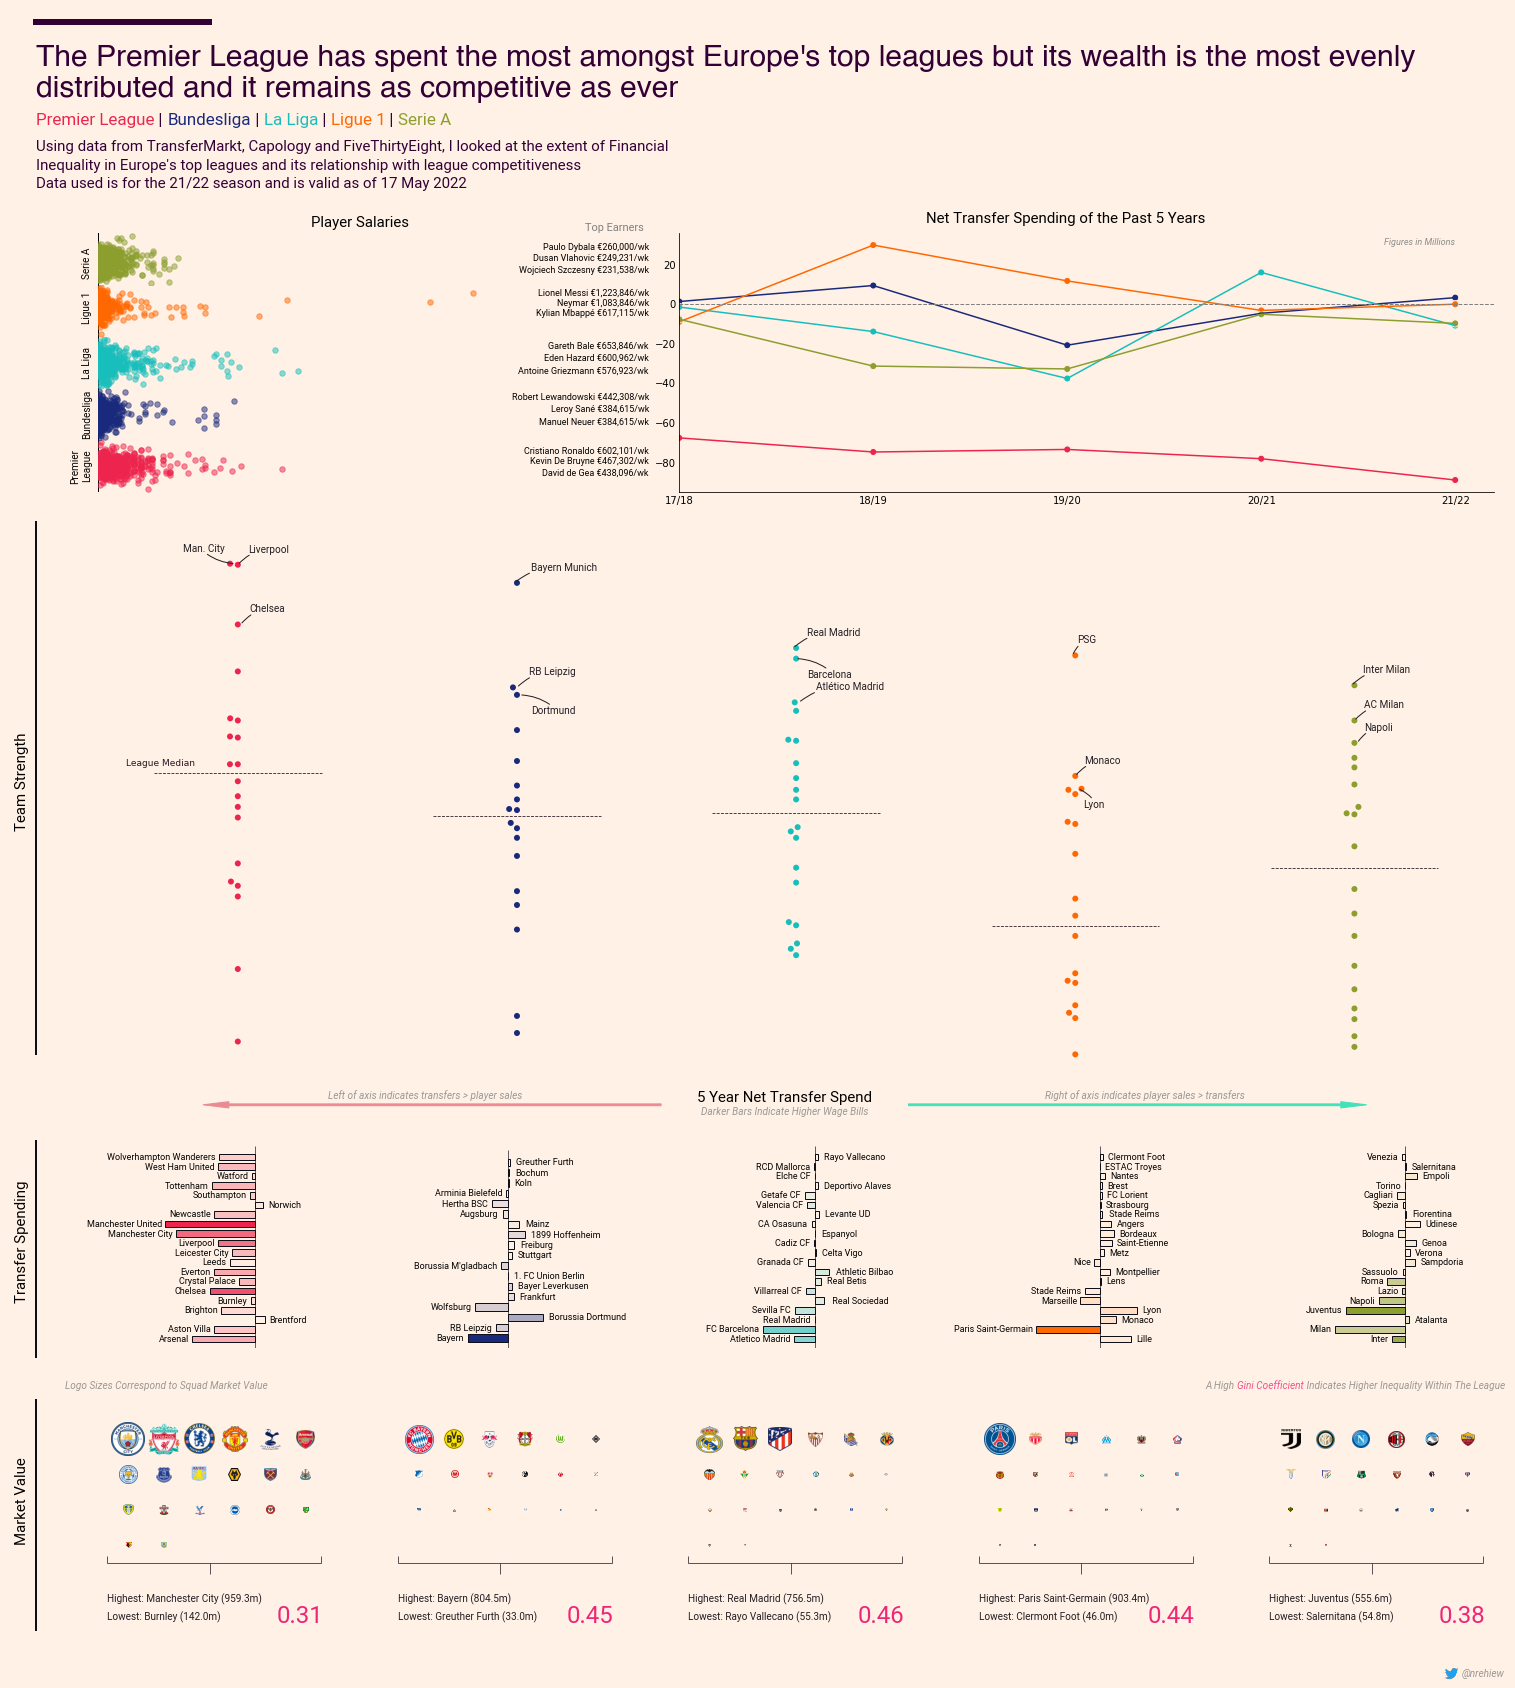

In [217]:
#styles 
width=0.7
edgecolor='#0E0F19'
bg_color = '#FFF1E5'
statcolor = '#2C1320'
textcolor = '#221D23'
# font = 'Bahnschrift'
font = 'Roboto'
ginicolor = '#EE2677'
fontsize = 10
axissize = 8
# colors = ['#DB5461','#3D5467','#3DA5D9','#D84797','#47A025']
colors = ['#ED254E','#19297C','#17BEBB','#FF6700','#8B9E2E']
title_color = '#330036'
title_size = 30
#title_font = 'Georgia'
title_font = 'Helvetica'
subtitle_size = 15
notes_size = 10

fig = plt.figure()
fig.set_size_inches(20,20)
fig.patch.set_facecolor(bg_color)
fig,axs = plot_master(fig,ratings,df,colors,statcolor,textcolor,font,fontsize,axissize,ginicolor,bg_color,upsets)

#padding
fig.text(-0.04,1.132,' ')

#text
fig.text(-0.02,1.075,"The Premier League has spent the most amongst Europe's top leagues but its wealth is the most evenly\ndistributed and it remains as competitive as ever",ha='left',font=title_font,size=title_size,color =title_color,fontweight='medium')
fig_text(-0.02,1.064,'<Premier League> | <Bundesliga> | <La Liga> | <Ligue 1> | <Serie A>',highlight_textprops=[{'color':colors[0]},{'color':colors[1]},{'color':colors[2]},{'color':colors[3]},{'color':colors[4]}],
           color=title_color,font=font,ha='left',size=subtitle_size+2,va='top')
fig.text(-0.02,1.045,"Using data from TransferMarkt, Capology and FiveThirtyEight, I looked at the extent of Financial\nInequality in Europe's top leagues and its relationship with league competitiveness \nData used is for the 21/22 season and is valid as of 17 May 2022",
        ha='left',va='top',color=title_color,font=font,size=subtitle_size,fontweight='regular',linespacing=1.4)
fig.text(1,-0.02,'@nrehiew',ha='right',va='center',font=font,fontsize=10,alpha=0.8,color='grey',fontstyle='italic')
ax = fig.add_axes([0.958,-0.025,0.01,0.01])
im = plt.imread(r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Visualisations\Assets\icon.png")
ax.imshow(im)
ax.axis('off')
# fig.text(0,0.785,'Bars represent the number of upsets in the 21/22 season',ha='left',va='center',font=font,fontsize=10,alpha=0.8,color='grey',)
# fig.text(0,0.778,'Upsets are wins which FiveThirtEight predicted a less than 20% probability of happening',ha='left',va='center',font=font,fontsize=10,alpha=0.8,color='grey')

#lines
fig.add_artist(lines.Line2D([-0.02,0.1],[1.127],linewidth=6,color=title_color))
fig.add_artist(lines.Line2D([-0.02,-0.02],[0.41,0.78],linewidth=2,color=edgecolor))
fig.add_artist(lines.Line2D([-0.02,-0.02],[0.2,0.35],linewidth=2,color=edgecolor))
fig.add_artist(lines.Line2D([-0.02,-0.02],[0.01,0.17],linewidth=2,color=edgecolor))
fig.text(-0.03,0.6,'Team Strength',ha='center',va='center',font=font,fontsize=15,rotation='vertical')
fig.text(-0.03,0.28,'Transfer Spending',ha='center',va='center',font=font,fontsize=15,rotation='vertical')
fig.text(-0.03,0.1,'Market Value',ha='center',va='center',font=font,fontsize=15,rotation='vertical')
ax = fig.add_axes([0.08,0.35,0.35,0.05])
arrow = ax.arrow(1,0.4,-1,0,width=0.02,head_width=0.07,head_length=0.06,color='#EB8A90')
ax.set_ylim([0,0.8])
ax.axis('off')
ax = fig.add_axes([0.57,0.35,0.35,0.05])
arrow = ax.arrow(0,0.4,1,0,width=0.02,head_width=0.07,head_length=0.06,color='#42E2B8')
ax.set_ylim([0,0.8])
ax.axis('off')
fig.text(0.25,0.382,'Left of axis indicates transfers > player sales',ha='center',va='center',font=font,fontsize=10,alpha=0.8,color='grey',fontstyle='italic')
fig.text(0.75,0.382,'Right of axis indicates player sales > transfers',ha='center',va='center',font=font,fontsize=10,alpha=0.8,color='grey',fontstyle='italic')
fig.text(0.5,0.38,'5 Year Net Transfer Spend',ha='center',va='center',font=font,fontsize=15)
fig.text(0.5,0.37,'Darker Bars Indicate Higher Wage Bills',ha='center',va='center',font=font,fontsize=10,alpha=0.8,color='grey',fontstyle='italic')
fig.text(0,0.18,'Logo Sizes Correspond to Squad Market Value',ha='left',va='center',font=font,fontsize=10,alpha=0.8,color='grey',fontstyle='italic')
_ = fig_text(1,0.18,s='A High <Gini Coefficient> Indicates Higher Inequality Within The League',highlight_textprops=[{'color':ginicolor}],ha='right',va='center',font=font,fontsize=10,alpha=0.8,color='grey',fontstyle='italic')
plt.savefig('Completed/leagues.jpg',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)